# Pulsar classification model - EDA and experiments

In this notebook we explore the dataset about pulsar classification obtained by Kaggle at this [link](https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star). 

The dataset is collection of about 17 thousand records classified as pulsar or not.
For each record, the following features are present.

- Mean integrated profile
- Standard deviation of the integrated profile
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.
- Class (`non stellar=0` and `pulsar=1`) 

Let's first import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, roc_auc_score
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

## Data ingestion

The dataset is rather clean and contained in a single CSV file.
We import it in a `pandas.DataFrame`.

In [2]:
DATA = "../data/pulsar_stars.csv"

data = pd.read_csv(DATA)

Let's give a look at the first few lines.

In [3]:
data.head()

Mean of the integrated profile  \
0                      140.562500   
1                      102.507812   
2                      103.015625   
3                      136.750000   
4                       88.726562   

    Standard deviation of the integrated profile  \
0                                      55.683782   
1                                      58.882430   
2                                      39.341649   
3                                      57.178449   
4                                      40.672225   

    Excess kurtosis of the integrated profile  \
0                                   -0.234571   
1                                    0.465318   
2                                    0.323328   
3                                   -0.068415   
4                                    0.600866   

    Skewness of the integrated profile   Mean of the DM-SNR curve  \
0                            -0.699648                   3.199833   
1                            -0.515088                   1.677258   
2                             1.051164                   3.121237   
3                            -0.636238                   3.642977   
4                             1.123492                   1.178930   

    Standard deviation of the DM-SNR curve  \
0                                19.110426   
1                                14.860146   
2                                21.744669   
3                                20.959280   
4                                11.468720   

    Excess kurtosis of the DM-SNR curve   Skewness of the DM-SNR curve  \
0                              7.975532                      74.242225   
1                             10.576487                     127.393580   
2                              7.735822                      63.171909   
3                              6.896499                      53.593661   
4                             14.269573                     252.567306   

   target_class  
0             0  
1             0  
2             0  
3             0  
4             0

We can describe the dataframe to have  feeling of the different features and of the base statistics.

In [4]:
data[data.columns.difference(['target_class'])].describe()

Excess kurtosis of the DM-SNR curve  \
count                          17898.000000   
mean                               8.303556   
std                                4.506092   
min                               -3.139270   
25%                                5.781506   
50%                                8.433515   
75%                               10.702959   
max                               34.539844   

        Excess kurtosis of the integrated profile   Mean of the DM-SNR curve  \
count                                17898.000000               17898.000000   
mean                                     0.477857                  12.614400   
std                                      1.064040                  29.472897   
min                                     -1.876011                   0.213211   
25%                                      0.027098                   1.923077   
50%                                      0.223240                   2.801839   
75%                                      0.473325                   5.464256   
max                                      8.069522                 223.392140   

        Skewness of the DM-SNR curve   Skewness of the integrated profile  \
count                   17898.000000                         17898.000000   
mean                      104.857709                             1.770279   
std                       106.514540                             6.167913   
min                        -1.976976                            -1.791886   
25%                        34.960504                            -0.188572   
50%                        83.064556                             0.198710   
75%                       139.309331                             0.927783   
max                      1191.000837                            68.101622   

        Standard deviation of the DM-SNR curve  \
count                             17898.000000   
mean                                 26.326515   
std                                  19.470572   
min                                   7.370432   
25%                                  14.437332   
50%                                  18.461316   
75%                                  28.428104   
max                                 110.642211   

        Standard deviation of the integrated profile  \
count                                   17898.000000   
mean                                       46.549532   
std                                         6.843189   
min                                        24.772042   
25%                                        42.376018   
50%                                        46.947479   
75%                                        51.023202   
max                                        98.778911   

       Mean of the integrated profile  
count                    17898.000000  
mean                       111.079968  
std                         25.652935  
min                          5.812500  
25%                        100.929688  
50%                        115.078125  
75%                        127.085938  
max                        192.617188

We can also check the number of null entries in the different columns.

In [5]:
data.isnull().sum()

Mean of the integrated profile                   0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64

There are no `null`'s, the data are clean. We can then rename columns to use simpler column names.

In [6]:
data = data.rename({
    'Mean of the integrated profile': 'avg_ip',
    ' Standard deviation of the integrated profile': 'std_ip',
    ' Excess kurtosis of the integrated profile': 'kur_ip',
    ' Skewness of the integrated profile': 'skw_ip',
    ' Mean of the DM-SNR curve': 'avg_dmsnr',
    ' Standard deviation of the DM-SNR curve': 'std_dmsnr',
    ' Excess kurtosis of the DM-SNR curve': 'kur_dmsnr', 
    ' Skewness of the DM-SNR curve': 'skw_dmsnr'
}, axis=1)

col_order = ['avg_ip', 'std_ip', 'kur_ip', 'skw_ip', 'avg_dmsnr', 'std_dmsnr', 'kur_dmsnr', 'skw_dmsnr']

## Exploratory data analysis

We start with a visual exploration of the feature distribution through a pair plot.

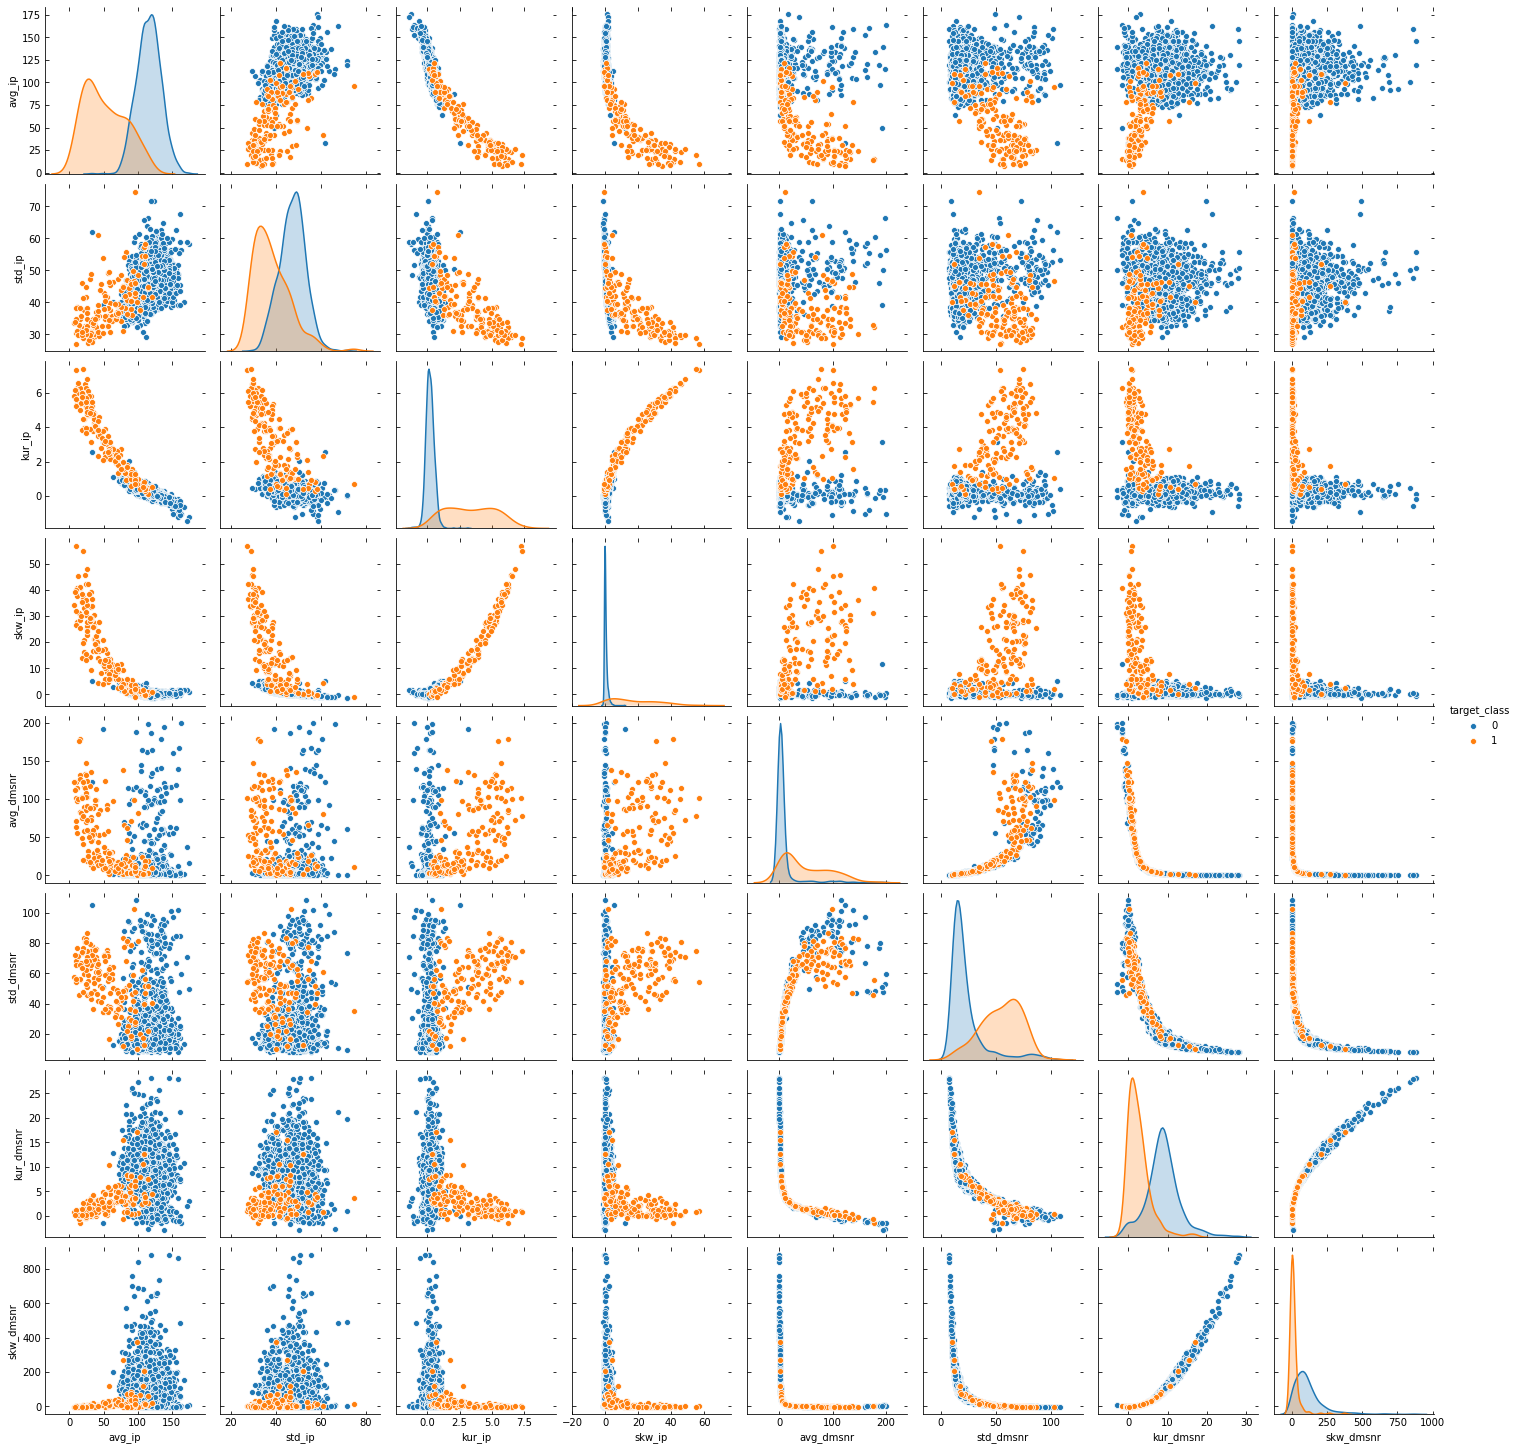

In [7]:
# Let's plot the pair plots
sns.pairplot(
    data.sample(frac=0.1, axis=0),
    hue="target_class",
    vars=col_order,
    #diag_kind='hist'
);

It looks like there are feature able to separate most of the distribution mass fo the two classes. For example `avg_ip` and `std_dmsnr`.

Some of the fetures also span a rather large range in of value in feature space. so they might benefit from a logarithmic transforamtion to rescale the features, or at least a MinMax scaling to bring all features to a similar range.

We can also explore correlation between features.

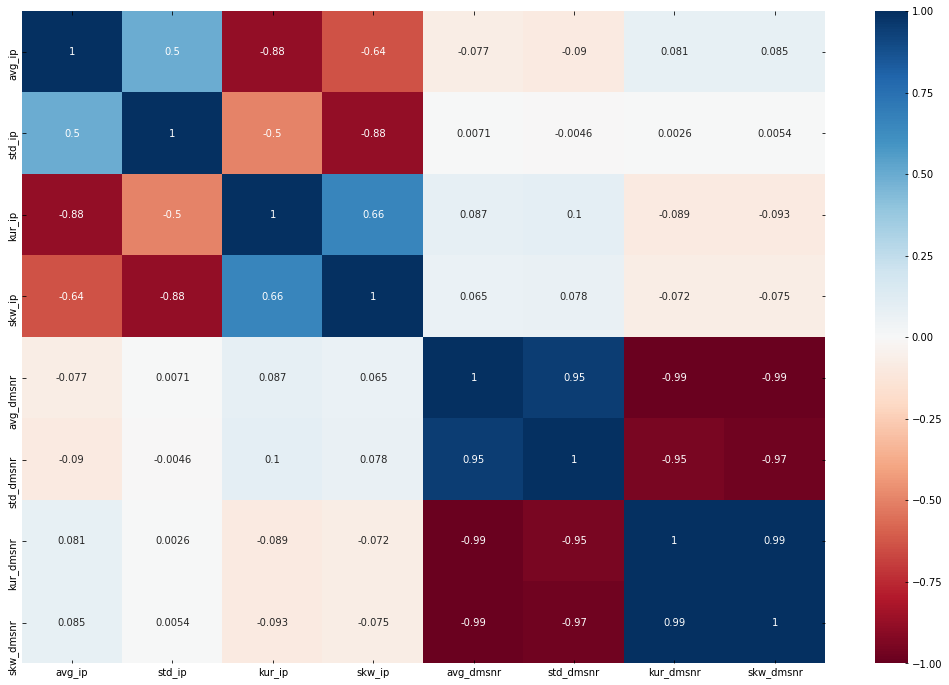

In [8]:
sns.heatmap(
    data[data.columns.difference(['target_class'])].corr(method='spearman').loc[col_order, col_order],
    vmin=-1,
    vmax=+1,
    cmap='RdBu',
    annot=True,
    ax=pl.figure(figsize=(18,12)).add_subplot(1,1,1)
);

The pairs `mean - std` and `skweness - kurtosis` show quite a strong correlation one with respect to the other. In general, the feature realte to both the integrated profile or the DM-SNR are quite correlated among each other.
However, the correlation si rather low between features belonging to one group (e.g. integrated profile) and features belongin to the other group (e.g. DM-SNR).
The least correlation is between the `ip_std` and the features related to the DM-SNR.

We can also plot the box-plot for each feature to see which one bettere separates the target variable when projected onto.

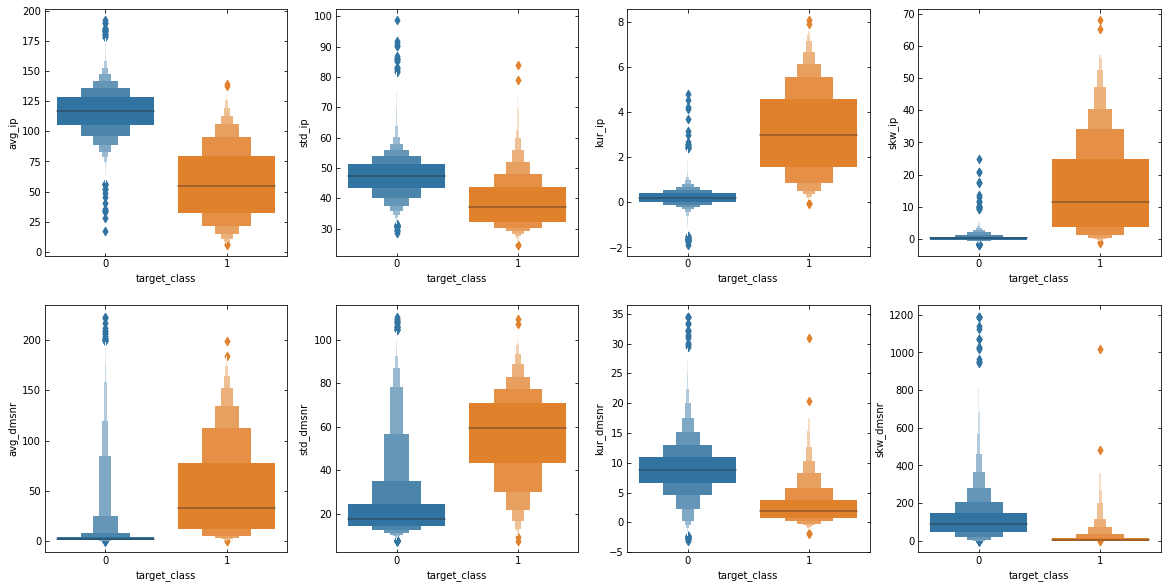

In [9]:
fig = pl.figure(figsize=(20,10))

for i in range(8):
    ax = fig.add_subplot(2,4,i + 1)

    sns.boxenplot(
        data=data,
        x='target_class',
        y=col_order[i],
        ax=ax
    )

The features that seem to separate the target classes are: `avg_ip`, `kur_ip`, and `std_dmsnr`.

### Conclusion of EDA

By considering correlation and separability of the dataset, we might suppose that the best features to keep are:
- `avg_ip`
- `kur_ip` or `skw_ip`
- `std_mnsrn`

## Feature selection

Let's try to investigate the relevance of features.

First, we use a univariated approach to check statistical correlation with the target variable.

In [10]:
featureImportance = pd.DataFrame(columns=col_order)

featureImportance.append(
    pd.DataFrame([
        GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=8).fit(data[col_order].values, data['target_class']).scores_
    ], columns=col_order, index=['mutual_info'])
).append(
    pd.DataFrame([
        GenericUnivariateSelect(score_func=f_classif, mode='k_best', param=8).fit(data[col_order].values, data['target_class']).scores_
    ], columns=col_order, index=['ANOVA'])
)

avg_ip       std_ip        kur_ip        skw_ip  \
mutual_info      0.192231     0.088239      0.226438      0.194512   
ANOVA        14830.932625  2728.251495  30033.327224  18143.230250   

               avg_dmsnr    std_dmsnr    kur_dmsnr    skw_dmsnr  
mutual_info     0.115749     0.119248     0.113393     0.115064  
ANOVA        3426.572386  5701.255353  3226.140850  1288.044817

From the univariate statistics, it looks like the most relevant features are `kur_ip`, `avg_ip`, `skw_ip` and `std_dmsnr`. In fact, `kur_ip` and `skw_ip` are strongly correlated, so we can probably use one of the two.

We can use a permutation test on a basic RandomForest to test further feature importance.
First, we try with all features.

In [11]:
def test_feature_importance(list_of_cols):
    clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1988).fit(data[list_of_cols].values, data['target_class'].values)
    baseline = clf.score(data[list_of_cols].values, data['target_class'].values)
    print("Baseline accuracy: ", baseline)

    result = permutation_importance(clf, data[list_of_cols].values, data['target_class'].values, scoring='accuracy', n_repeats=30, random_state=42)

    perm_sorted_idx = result.importances_mean.argsort().astype(int)

    return sns.boxplot(
        data=pd.DataFrame(result.importances[perm_sorted_idx].T, columns=np.array(list_of_cols)[perm_sorted_idx]), 
        showfliers = False
    )

Baseline accuracy:  0.9782098558498156


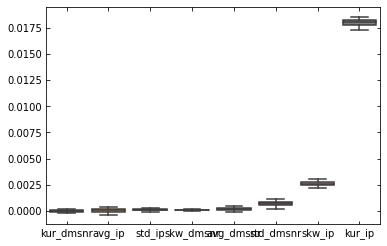

In [12]:
test_feature_importance(col_order);

Then, we try with different subset of features.

Baseline accuracy:  0.9788244496591798


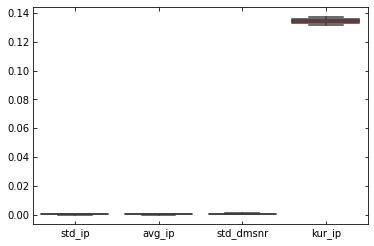

In [13]:
my_col = ['avg_ip', 'std_ip', 'kur_ip', 'std_dmsnr']
test_feature_importance(my_col);

Baseline accuracy:  0.9783774723432785


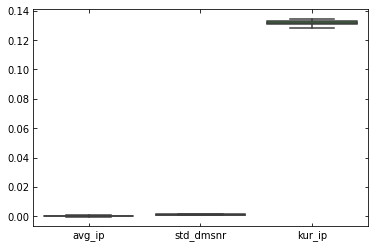

In [14]:
my_col = ['avg_ip', 'kur_ip', 'std_dmsnr']
test_feature_importance(my_col);

Baseline accuracy:  0.9790479383171304


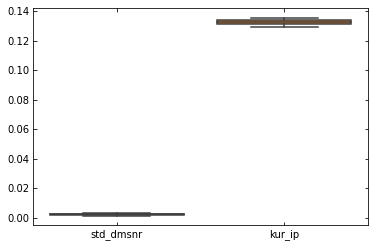

In [15]:
my_col = ['kur_ip', 'std_dmsnr']
test_feature_importance(my_col);

We see that every approach suggests that `kur_ip` is the most relevant feature.
Then, whether we use the whole feature set, or a subsample based on the features from the integrated profile, it does not change that much the overall perfomraces.

## Model set up

### Train/test split, data preparation and model CV

First, let'split the train and test set as 80/20, respectively. We use the whole set of features.

In [16]:
X = data[col_order].values
y = data['target_class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data['target_class'].values, random_state=1988)

We define data renormalization on the train set

In [17]:
data_scaler = MinMaxScaler().fit(X_train)

We scale the training set features to use them confortably for model cross validation.

In [18]:
X_train_scaled = data_scaler.transform(X_train)

We now define the base model we want to test, namely a RandomForest.

In [19]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, class_weight="balanced_subsample")

Let's build the cross-validation strategy.

We test the effect of augmenting the number of trees and their maximum depth.

In [21]:
cv_search = GridSearchCV(
    estimator=clf,
    param_grid={
        "n_estimators": [10, 20, 50, 100, 200, 500],
        "max_depth": [1, 2, 3, 4, 6, 8]
    },
    scoring={'matthews': make_scorer(matthews_corrcoef), 'accuracy': make_scorer(accuracy_score)},
    n_jobs=-1,
    cv=5,
    return_train_score=True,
    refit=False
)

In [22]:
cv_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              max_depth=3),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 6, 8],
                         'n_estimators': [10, 20, 50, 100, 200, 500]},
             refit=False, return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'matthews': make_scorer(matthews_corrcoef)})

We print the cross-validation results, first in textual form, than as heatmap as function of the explored parameters.

In [23]:
def report_cv_results(results):
    experiment_labels = [' '.join([f'{k}={v}' for k,v in run_param.items()]) for run_param in results.get('params')]
    list_of_scoring = list(map(lambda x: x[len('mean_test_'):], filter(lambda x: x.startswith('mean_test_'), results.keys())))
    for i, current_experiment in enumerate(experiment_labels):
        table_row = f'{current_experiment}\t'
        for current_metric in list_of_scoring:
            train_val = results.get(f'mean_train_{current_metric}')[i]
            test_val = results.get(f'mean_test_{current_metric}')[i]
            table_row = f'{table_row}train_{current_metric}={train_val:.3f}/test_{current_metric}={test_val:.3f}/delta={(train_val - test_val):.3f}\t'
        print(table_row)
    
    for current_metric in list_of_scoring:
        top_model_index = np.argmax(results.get(f'mean_test_{current_metric}'))
        print(
            f'\nMETRIC={current_metric} TOP MODEL={experiment_labels[top_model_index]} '
            f'TRAIN={results.get(f"mean_train_{current_metric}")[top_model_index]} '
            f'TEST={results.get(f"mean_test_{current_metric}")[top_model_index]} '
            f'DELTA={np.fabs(results.get(f"mean_train_{current_metric}")[top_model_index] - results.get(f"mean_test_{current_metric}")[top_model_index]) / results.get(f"mean_test_{current_metric}")[top_model_index]}'
        )
    
    for current_metric in list_of_scoring:
        top_model_index = np.argmin(np.fabs(results.get(f"mean_train_{current_metric}")[top_model_index] - results.get(f"mean_test_{current_metric}")[top_model_index]) / results.get(f"mean_test_{current_metric}")[top_model_index])
        print(
            f'\nMETRIC={current_metric} MINIMUM OVERFITTING={experiment_labels[top_model_index]} '
            f'TRAIN={results.get(f"mean_train_{current_metric}")[top_model_index]} '
            f'TEST={results.get(f"mean_test_{current_metric}")[top_model_index]} '
            f'DELTA={results.get(f"mean_train_{current_metric}")[top_model_index] - results.get(f"mean_test_{current_metric}")[top_model_index]}'
        )
    
    return

# Print results
report_cv_results(cv_search.cv_results_)

max_depth=1 n_estimators=10	train_matthews=0.789/test_matthews=0.789/delta=0.000	train_accuracy=0.962/test_accuracy=0.962/delta=0.000	
max_depth=1 n_estimators=20	train_matthews=0.788/test_matthews=0.783/delta=0.004	train_accuracy=0.962/test_accuracy=0.961/delta=0.001	
max_depth=1 n_estimators=50	train_matthews=0.799/test_matthews=0.800/delta=-0.000	train_accuracy=0.964/test_accuracy=0.965/delta=-0.000	
max_depth=1 n_estimators=100	train_matthews=0.805/test_matthews=0.801/delta=0.003	train_accuracy=0.966/test_accuracy=0.965/delta=0.001	
max_depth=1 n_estimators=200	train_matthews=0.793/test_matthews=0.793/delta=-0.000	train_accuracy=0.963/test_accuracy=0.963/delta=-0.000	
max_depth=1 n_estimators=500	train_matthews=0.798/test_matthews=0.793/delta=0.005	train_accuracy=0.964/test_accuracy=0.963/delta=0.001	
max_depth=2 n_estimators=10	train_matthews=0.820/test_matthews=0.820/delta=0.001	train_accuracy=0.968/test_accuracy=0.968/delta=0.000	
max_depth=2 n_estimators=20	train_matthews=0.825

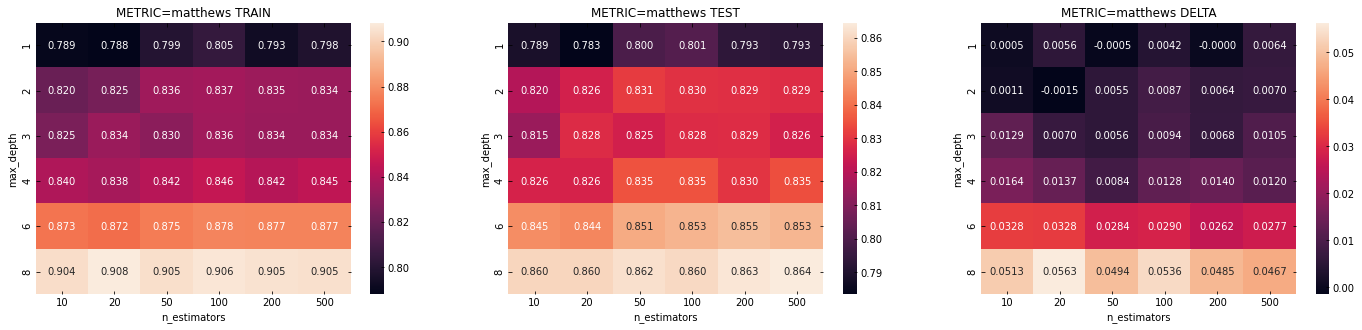

In [24]:
def make_map(results, score):
    
    fig = pl.figure(figsize=(24,5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    
    sns.heatmap(
        data=pd.DataFrame(results.get(f'mean_train_{score}').reshape((6, 6)), index=np.unique(results.get('param_max_depth').data.reshape((6, 6))), columns=np.unique(results.get('param_n_estimators').data.reshape((6, 6)))),
        annot=True,
        fmt='.3f',
        ax=ax1
    )
    sns.heatmap(
        data=pd.DataFrame(results.get(f'mean_test_{score}').reshape((6, 6)), index=np.unique(results.get('param_max_depth').data.reshape((6, 6))), columns=np.unique(results.get('param_n_estimators').data.reshape((6, 6)))),
        annot=True,
        fmt='.3f',
        ax=ax2
    )
    sns.heatmap(
        data=pd.DataFrame(((results.get(f'mean_train_{score}') - results.get(f'mean_test_{score}')) / results.get(f'mean_test_{score}')).reshape((6, 6)), index=np.unique(results.get('param_max_depth').data.reshape((6, 6))), columns=np.unique(results.get('param_n_estimators').data.reshape((6, 6)))),
        annot=True,
        fmt='.4f',
        ax=ax3
    )
    
    ax1.set(title=f'METRIC={score} TRAIN', xlabel='n_estimators', ylabel='max_depth')
    ax2.set(title=f'METRIC={score} TEST', xlabel='n_estimators', ylabel='max_depth')
    ax3.set(title=f'METRIC={score} DELTA', xlabel='n_estimators', ylabel='max_depth')
    return

make_map(cv_search.cv_results_, 'matthews')
make_map(cv_search.cv_results_, 'accuracy')

It looks like that the model complexit is mostly dominated by the depth of the trees, and very mildly by the number of trees.

With more trees, the scores increase, but the relative variation between the train and test set results increase more slowly than along the tree depth.

It looks like that the best trade off between overfitting and model results is achieved for `max_depth=4` and `n_estimators >= 50`.

### Create final model and evalutate performances

First, let's define the final model and combine it in a pipeline to incorporate input feature scaling.

We choose `max_depth=4` and `n_estimators=100`.

In [25]:
model = Pipeline([('scaling', data_scaler), ('classifier', RandomForestClassifier(n_estimators=100, max_depth=4, class_weight="balanced_subsample", random_state=1988))])

First, we evaluate the model performances by using 5-folds Cross Validation and averaging the results on the tested folds.

In [27]:
print(f'CV Accuracy   = {cross_val_score(model, X, y, scoring=make_scorer(accuracy_score), cv=5).mean()}')
print(f'CV Precision  = {cross_val_score(model, X, y, scoring=make_scorer(precision_score), cv=5).mean()}')
print(f'CV Recall     = {cross_val_score(model, X, y, scoring=make_scorer(recall_score), cv=5).mean()}')
print(f'CV Matthews   = {cross_val_score(model, X, y, scoring=make_scorer(matthews_corrcoef), cv=5).mean()}')

CV Accuracy   = 0.9697173455960513
CV Precision  = 0.8045333869270795
CV Recall     = 0.8938446334004626
CV Matthews   = 0.8308096210911753


Then, we train the model on the training set and we evaluate performances on the test set.

In [28]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=4, random_state=1988))])

In [29]:
y_test_pred = model.predict(X_test)

print(f"TEST Accuracy  = {accuracy_score(y_test, y_test_pred):.4f}")
print(f"TEST Precision = {precision_score(y_test, y_test_pred):.4f}")
print(f"TEST Recall    = {recall_score(y_test, y_test_pred):.4f}")
print(f"TEST Matthews  = {matthews_corrcoef(y_test, y_test_pred):.4f}")
pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=['Real Neg', 'Real Pos'], columns=['Pred Neg', 'Pred Pos'])

TEST Accuracy  = 0.9735
TEST Precision = 0.8282
TEST Recall    = 0.8963
TEST Matthews  = 0.8471


Pred Neg  Pred Pos
Real Neg      3191        61
Real Pos        34       294

In [31]:
def draw_roc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    fig = pl.figure(figsize=(6, 6))
    ax = fig.add_subplot(1,1,1)
    ax.fill_between(fpr, tpr, 0, color='#e0e0e0')
    ax.plot([0,1], [0,1], ':k', lw=1)
    ax.plot(fpr, tpr, ds='steps-post', lw=5)
    ax.minorticks_on()
    ax.set(xlim=[0, 1], ylim=[0, 1], xlabel='FPR', ylabel='TPR')
    ax.text(0.5, 0.25, f'AUC={roc_auc_score(y_true, y_pred):.3f}', fontsize=16)

draw_roc(y_test, model.predict_proba(X_test)[:, 1])

## Conclusions

We created a simple classifier model based on a RandomForest to predict whether a source is a pulsar based on the statistics of the integrated profile and the DM-SNR.

We explored feature importance and we cross-validated model hyperparameters.
It seems that 3 out of 8 are significant features, although using all features or just a subset of them does not alter the model performances significantly.

We obtained a classifier with a generalization performances as follows.
- accuracy: 97%
- precision: 80%
- recall: 90%
- Matthews correlation: 0.83
- AUC: 0.97